<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-4" data-toc-modified-id="Project-4-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project 4</a></span></li><li><span><a href="#Electricity-Prediction" data-toc-modified-id="Electricity-Prediction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Electricity Prediction</a></span><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Modelisation" data-toc-modified-id="Modelisation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modelisation</a></span></li><li><span><a href="#Hyperparameters-tuning-for-best-models" data-toc-modified-id="Hyperparameters-tuning-for-best-models-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Hyperparameters tuning for best models</a></span></li><li><span><a href="#Features-importance" data-toc-modified-id="Features-importance-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Features importance</a></span></li></ul></li><li><span><a href="#CO2-prediction" data-toc-modified-id="CO2-prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CO2 prediction</a></span><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Modelisation" data-toc-modified-id="Modelisation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modelisation</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Features-importance" data-toc-modified-id="Features-importance-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Features importance</a></span></li></ul></li><li><span><a href="#Energy-Stars-score-influence" data-toc-modified-id="Energy-Stars-score-influence-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy Stars score influence</a></span><ul class="toc-item"><li><span><a href="#Energy" data-toc-modified-id="Energy-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Energy</a></span></li><li><span><a href="#CO2" data-toc-modified-id="CO2-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CO2</a></span></li></ul></li><li><span><a href="#Other" data-toc-modified-id="Other-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Other</a></span></li></ul></div>

# Project 4

The objectif of this project is to predict the CO2 emissions and electricity consumption of buildings in Seatle.  
The project is divided into two notebooks:  
- One with data exploratory analysis, where the data will be transformed  
- One with the prediction  
***
The following notebook is dedicated to the prediction of the CO2 and electricity. It is divided into two parts: the Electricity prediction and the CO2 emission prediction. Lastly, we will study the importance of the EnergyScore feature.

In [1]:
#Data manipulation
import pandas as pd
import numpy as np

#Graphical
# %pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model, svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection, preprocessing
# !pip3 install xgboost
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("data/cleaned_dataframe.csv")

#Get a DF for electricity study and another for the CO2
dfe = df.drop(columns='GHGEmissions(MetricTonsCO2e)')
dfc = df.drop(columns="SiteEnergyUse(kBtu)")

# Electricity Prediction

## Data Preprocessing 

In [3]:
# %reset

During the data exploratory, we notice that the features don't have the same order of magnitude, hence we have to standardize the data. Plus the electricity and CO2 are very disparate, we will use the log() to reduce it. 

In [4]:
#All features
X = dfe.iloc[:,:-1]
#Use the log function on the electricity, since it has a huge disparity
y = dfe.iloc[:,-1].map(lambda x: np.log(x+1))

#Split the dataset and standardization
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)
std_scaler = preprocessing.StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

## Modelisation

We will first study the result from different algorithms, then conduct a hyperparameter tuning for the two best algorithms.

In [5]:
def compute_output(clf, X_train, y_train, X_test):
    """Fit the classifier and predict the output"""
    clf.fit(X_train,y_train)
    y_pred_fnc = clf.predict(X_test)
    return y_pred_fnc

In [6]:
#Electricity prediction
classifiers = []

classifiers.append(RandomForestRegressor(n_jobs=-1, n_estimators=100))
classifiers.append(xgb.XGBRegressor(objective="reg:squarederror", random_state=42))
classifiers.append(GradientBoostingRegressor(n_estimators=100))
classifiers.append(DecisionTreeRegressor())
classifiers.append(KNeighborsRegressor(n_jobs=8, n_neighbors=5, weights='distance', p=2))
classifiers.append(svm.SVR(gamma="auto"))
classifiers.append(svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
classifiers.append(linear_model.Ridge())
classifiers.append(linear_model.Lasso(alpha=0.1))

y_pred_all = []
error_all = []

for i,clf in enumerate(classifiers):
    y_pred_all.append(compute_output(clf,X_train_std, y_train, X_test_std))
    error_all.append(metrics.mean_squared_error(y_test, y_pred_all[i]))
#     error_test.append(metrics.mean_squared_error(y_test, y_pred_test[i]))

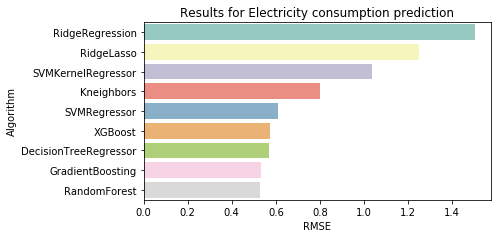

In [7]:
def draw_result(results,algorithm_name,title):
    cv_res = pd.DataFrame({"RMSE":results,"Algorithm":algorithm_name})
    new_idx = cv_res.RMSE.sort_values(ascending=False).index
    cv_res = cv_res.reindex(new_idx)
    g = sns.barplot("RMSE","Algorithm",data = cv_res, palette="Set3",orient = "h")
    g.set_xlabel("RMSE")
#     g.set(xlim=(0,2))#max(cv_res["R2_score"]
    g = g.set_title(title) 
    
algo = ["RandomForest","XGBoost","GradientBoosting","DecisionTreeRegressor","Kneighbors",
        "SVMRegressor","SVMKernelRegressor","RidgeRegression","RidgeLasso"]

figure = plt.figure(figsize=(7,6))
# plt.subplot(211)
# draw_result(error_all1,algo,"Results for CO2 emission prediction")
plt.subplot(212)
draw_result(error_all,algo,"Results for Electricity consumption prediction")
figure.tight_layout(pad=1.0)

In [8]:
res = pd.DataFrame({"Algorithm":algo,"Rmse_score_elec":error_all})
new_idx = res.Rmse_score_elec.sort_values(ascending=True).index
res = res.reindex(new_idx)
res = res[:2]
print(res)

          Algorithm  Rmse_score_elec
0      RandomForest         0.526306
2  GradientBoosting         0.532330


## Hyperparameters tuning for best models

I performed a grid search optimization for RandomForest, XGboost regressor models.

In [9]:
# # Grid Search CV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 7)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
# # max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [5, 10, 15, 100]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [5, 10, 15]
# # Method of selecting samples for training each tree
# # bootstrap = [True, False]

# # Create the random grid
# rf_param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# rfr = RandomForestRegressor()

# # rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, 
# #                                verbose=2, random_state=42, n_jobs = -1)

# gs_rfr = model_selection.GridSearchCV(rfr,param_grid = rf_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs= -1)

# gs_rfr.fit(X_train_std,y_train)

# rfr_best = gs_rfr.best_estimator_
# print(gs_rfr.best_params_)

# # Best score
# print(gs_rfr.best_score_)

{'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}

In [10]:
# #Standard values
# learning_rate: 0.01
# n_estimators: 100 if the size of your data is high, 1000 is if it is medium-low
# max_depth: 3
# subsample: 0.8
# colsample_bytree: 1
# gamma: 1

In [11]:
# #Extrem Gradient Boosting Tuning

# xgb_r = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     n_estimators=1000,
#     max_depth=5,
#     min_child_weight=1,
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27)

# xgb_param_grid = {'colsample_bytree': [0.3,0.5,0.7],'learning_rate': [0.3,0.1,0.07],
#             'max_depth': [3,5,7], 'alpha': [5,10,15]}

# gs_xgb = model_selection.GridSearchCV(xgb_r, param_grid=xgb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

# gs_xgb.fit(X_train_std,y_train)

# xgb_best = gs_xgb.best_estimator_
# print(gs_xgb.best_params_)

# # Best score
# print(gs_xgb.best_score_)

{'learning_rate': 0.05, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 50, 'n_estimators': 300}

**Results**

In [12]:
RMSE_score_opti_elec = []

#Results with the best params
rfr_optie = RandomForestRegressor(max_depth=17,min_samples_leaf=5,min_samples_split=5,
                                  n_estimators=100,max_features='auto',)
rfr_optie.fit(X_train_std,y_train)

xgb_optie = XGBRegressor(objective="reg:squarederror",learning_rate=0.05, random_state=42, 
                        max_depth= 10, max_features= 0.1, min_samples_leaf= 50, n_estimators=300)
xgb_optie.fit(X_train_std,y_train)

RMSE_score_opti_elec.append(metrics.mean_squared_error(y_test,rfr_optie.predict(X_test_std)))
RMSE_score_opti_elec.append(metrics.mean_squared_error(y_test,xgb_optie.predict(X_test_std)))

res["Rmse_score_opti_elec"] = RMSE_score_opti_elec

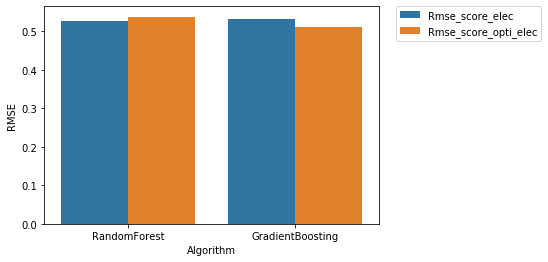

In [13]:
#Compare results
fig, ax1 = plt.subplots(nrows=1,ncols=1)

tidy = res.melt(id_vars='Algorithm').rename(columns=str.title)
tidy.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Features importance

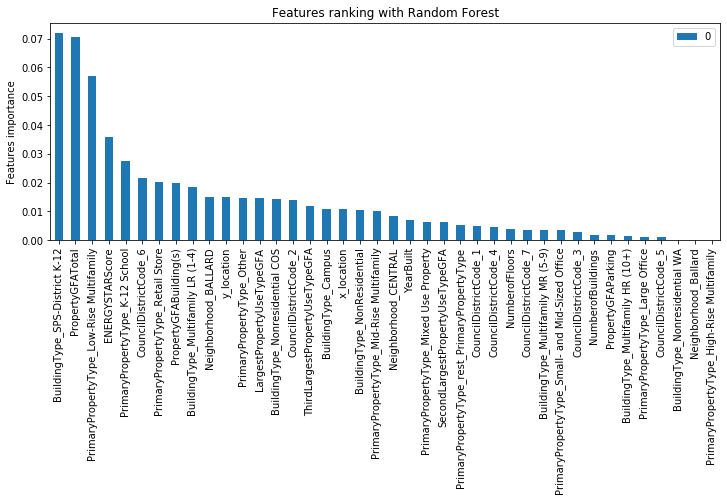

In [14]:
# Features importances:
# xgb_optie.fit(X_train_std,y_train)
pd.DataFrame(xgb_optie.feature_importances_[:40],index=X_train.columns[:40]).sort_values(
    by=0,ascending=False).plot(kind='bar',figsize=(12,4))
plt.ylabel('Features importance')
plt.title('Features ranking with Random Forest')
plt.show()

# CO2 prediction

## Data Preprocessing

In [15]:
#All features
X1 = dfc.iloc[:,:-1]
#Use the log function on the output due to the outliers
y1 = dfc.iloc[:,-1].map(lambda x: np.log(x+1))

#Split the dataset and standardization
X_train1, X_test1, y_train1, y_test1 = model_selection.train_test_split(X1, y1, test_size = 0.3)
std_scaler1 = preprocessing.StandardScaler()
X_train_std1 = std_scaler1.fit_transform(X_train1)
X_test_std1 = std_scaler1.transform(X_test1)

## Modelisation

In [16]:
#CO2 prediction
classifiers1 = []

classifiers1.append(RandomForestRegressor(n_jobs=-1, n_estimators=100))
classifiers1.append(xgb.XGBRegressor(objective="reg:squarederror", random_state=42))
classifiers1.append(GradientBoostingRegressor(n_estimators=100))
classifiers1.append(DecisionTreeRegressor())
classifiers1.append(KNeighborsRegressor(n_jobs=8, n_neighbors=5, weights='distance', p=2))
classifiers1.append(svm.SVR(gamma="auto"))
classifiers1.append(svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
classifiers1.append(linear_model.Ridge())
classifiers1.append(linear_model.Lasso(alpha=0.1))

y_pred_all1 = []
error_all1 = []

for i,clf in enumerate(classifiers1):
    y_pred_all1.append(compute_output(clf,X_train_std1, y_train1, X_test_std1))
    error_all1.append(metrics.mean_squared_error(y_test1, y_pred_all1[i]))
#     error_test.append(metrics.mean_squared_error(y_test, y_pred_test[i]))

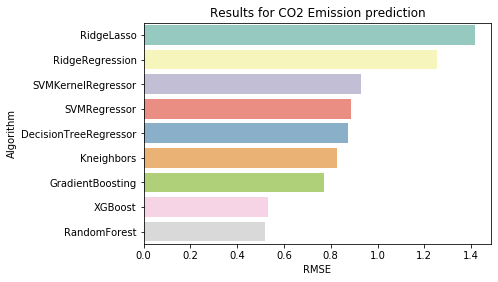

In [17]:
figure = plt.figure(figsize=(7,4))
draw_result(error_all1,algo,"Results for CO2 Emission prediction")
figure.tight_layout(pad=1.0)

In [18]:
res1 = pd.DataFrame({"Algorithm":algo,"Rmse_score_co2":error_all1})
new_idx = res1.Rmse_score_co2.sort_values(ascending=True).index
res1 = res1.reindex(new_idx)
res1 = res1[:2]

## Optimization

In [19]:
# # Grid Search CV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 7)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
# # max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [5, 10, 15, 100]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [5, 10, 15]
# # Method of selecting samples for training each tree
# # bootstrap = [True, False]

# # Create the random grid
# rf_param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# rfr = RandomForestRegressor()

# # rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, 
# #                                verbose=2, random_state=42, n_jobs = -1)

# gs_rfr = model_selection.GridSearchCV(rfr,param_grid = rf_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs= -1)

# gs_rfr.fit(X_train_std1,y_train1)

# rfr_best = gs_rfr.best_estimator_
# print(gs_rfr.best_params_)

# # Best score
# print(gs_rfr.best_score_)

{'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}

In [20]:
# #Standard values
# learning_rate: 0.01
# n_estimators: 100 if the size of your data is high, 1000 is if it is medium-low
# max_depth: 3
# subsample: 0.8
# colsample_bytree: 1
# gamma: 1

In [21]:
# #Extrem Gradient Boosting Tuning

# xgb_r = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     n_estimators=1000,
#     max_depth=5,
#     min_child_weight=1,
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27)

# xgb_param_grid = {'colsample_bytree': [0.3,0.5,0.7],'learning_rate': [0.3,0.1,0.07],
#             'max_depth': [3,5,7], 'alpha': [5,10,15]}

# gs_xgb = model_selection.GridSearchCV(xgb_r, param_grid=xgb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)

# gs_xgb.fit(X_train_std1,y_train1)

# xgb_best = gs_xgb.best_estimator_
# print(gs_xgb.best_params_)

# # Best score
# print(gs_xgb.best_score_)

{'alpha': 5, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 7}

**Results**

In [22]:
RMSE_score_opti_co2 = []

#Results with the best params
rfr_optic = RandomForestRegressor(max_depth=30,min_samples_leaf=5,min_samples_split=10,n_estimators=200)
rfr_optic.fit(X_train_std1,y_train1)
RMSE_score_opti_co2.append(metrics.mean_squared_error(y_test1,rfr_optic.predict(X_test_std1)))

xgb_optic = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, alpha=5,colsample_bytree=0.3,
                             learning_rate=0.1, max_depth=7)
xgb_optic.fit(X_train_std1,y_train1)
RMSE_score_opti_co2.append(metrics.mean_squared_error(y_test1,xgb_optic.predict(X_test_std1)))

res1["Rmse_score_opti_co2"] = RMSE_score_opti_co2

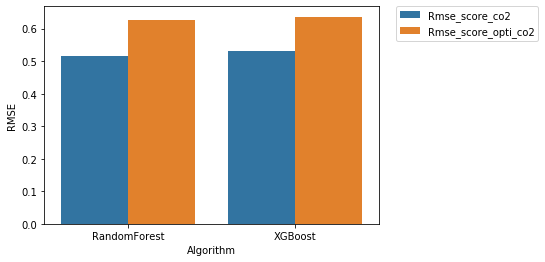

In [23]:
#Compare results
fig, ax1 = plt.subplots()

tidy1 = res1.melt(id_vars='Algorithm').rename(columns=str.title)
tidy1.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy1, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Features importance

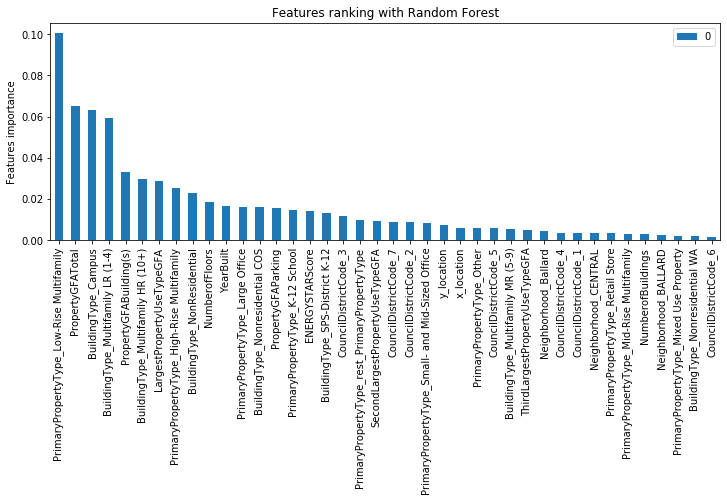

In [24]:
# Features importances:
# xgb_optic.fit(X_train_std1,y_train1)
pd.DataFrame(xgb_optic.feature_importances_[:40],index=X_train.columns[:40]).sort_values(
    by=0,ascending=False).plot(kind='bar',figsize=(12,4))
plt.ylabel('Features importance')
plt.title('Features ranking with Random Forest')
plt.show()

# Energy Stars score influence

## Energy

In [25]:
#Influence on the Electricity
X_train_e = X_train.drop(columns="ENERGYSTARScore")
X_test_e = X_test.drop(columns="ENERGYSTARScore")

std_scaler2 = preprocessing.StandardScaler()
X_train_stde = std_scaler2.fit_transform(X_train_e)
X_test_stde = std_scaler2.transform(X_test_e)

xgbr_e = xgb.XGBRegressor()
xgbr_e.fit(X_train_stde,y_train)

rfr_e = RandomForestRegressor(n_estimators=100)
rfr_e.fit(X_train_stde,y_train)

RMSE_score_opti_e_nrj = []

RMSE_score_opti_e_nrj.append(metrics.mean_squared_error(y_test,rfr_e.predict(X_test_stde)))
RMSE_score_opti_e_nrj.append(metrics.mean_squared_error(y_test,xgbr_e.predict(X_test_stde)))

res["Rmse_score_opti_e_nrj"] = RMSE_score_opti_e_nrj

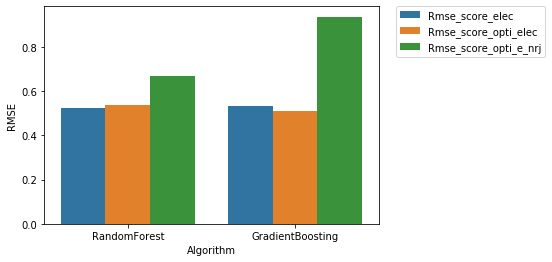

In [26]:
#Compare results
fig, ax1 = plt.subplots()

tidy2 = res.melt(id_vars='Algorithm').rename(columns=str.title)
tidy2.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy2, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## CO2

In [27]:
#Influence on the Electricity
X_train_c = X_train1.drop(columns="ENERGYSTARScore")
X_test_c = X_test1.drop(columns="ENERGYSTARScore")

std_scaler3 = preprocessing.StandardScaler()
X_train_stdc = std_scaler3.fit_transform(X_train_c)
X_test_stdc = std_scaler3.transform(X_test_c)

xgbr_c = xgb.XGBRegressor()
xgbr_c.fit(X_train_stdc,y_train1)

rfr_c = RandomForestRegressor(n_estimators=100)
rfr_c.fit(X_train_stdc,y_train1)

RMSE_score_opti_c_nrj = []

RMSE_score_opti_c_nrj.append(metrics.mean_squared_error(y_test1,rfr_c.predict(X_test_stdc)))
RMSE_score_opti_c_nrj.append(metrics.mean_squared_error(y_test1,xgbr_c.predict(X_test_stdc)))

res1["Rmse_score_opti_c_nrj"] = RMSE_score_opti_c_nrj

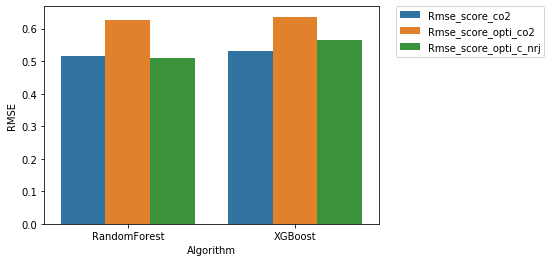

In [28]:
#Compare results
fig, ax1 = plt.subplots()

tidy3 = res1.melt(id_vars='Algorithm').rename(columns=str.title)
tidy3.rename(columns={"Variable": "Features", "Value": "RMSE"},inplace=True)

sns.barplot(x='Algorithm', y='RMSE', hue='Features', data=tidy3, ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Other

**PCA**

In [29]:
# def pca_decomposition(X_train_fnc,X_test_fnc,keep_components,components):
#     """This function computes a PCA on the train/test dataset"""
#     if keep_components:
#         pca_fnc = decomposition.PCA(svd_solver='auto')
#     else:
#         pca_fnc = decomposition.PCA(svd_solver='auto',n_components=components)
#     X_train_pca = pd.DataFrame(pca_fnc.fit_transform(X_train_fnc))
#     X_test_pca = pd.DataFrame(pca_fnc.transform(X_test_fnc))
#     return X_train_pca, X_test_pca, pca_fnc

# def plot_eigenvalues(eig_values): 
#     """Plot the eigenvalues of the PCA"""
#     plt.figure(figsize=(12,4))
#     plt.grid()
#     # plt.plot(np.log(eig_values.abs().values),'.')
#     plt.plot((eig_values.abs().values),'.')
#     # plt.xticks(np.arange(X_train_std.shape[1]),rotation=90)
#     # plt.vlines(x=27.5, ymin=0, ymax=0.2, colors='r', linestyles='--')
#     plt.title('PCA')
#     plt.ylabel('Variance explained')
#     plt.xlabel('Eigenvalues')
#     plt.show()

# # Get the new X train and test with the PCA
# X_train_pca, X_test_pca, pca = pca_decomposition(X_train_std,X_test_std,True,65)

# # Eigenvalues of covariance matrix (X_train) sorted desc:
# eig_values = pd.DataFrame(pca.explained_variance_ratio_)
# plot_eigenvalues(eig_values)

In [30]:
# classifiers_pca = []

# classifiers_pca.append(RandomForestRegressor(n_jobs=-1, n_estimators=100))
# classifiers_pca.append(GradientBoostingRegressor(n_estimators=100))
# classifiers_pca.append(DecisionTreeRegressor())
# classifiers_pca.append(KNeighborsRegressor(n_jobs=8, n_neighbors=5, weights='distance', p=2))
# classifiers_pca.append(svm.SVR(gamma="auto"))
# classifiers_pca.append(svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
# classifiers_pca.append(linear_model.Ridge())
# classifiers_pca.append(linear_model.Lasso(alpha=0.1))

# y_pred_pca = []
# error_pca = []

# for i,clf in enumerate(classifiers_pca):
#     y_pred_pca.append(compute_output(clf,X_train_pca, y_train, X_test_pca))
#     error_pca.append(metrics.r2_score(y_test, y_pred_pca[i]))
# #     error_test.append(metrics.mean_squared_error(y_test, y_pred_test[i]))